# Eclipsing binary: Solving for *everything* the fast way

In this notebook, we're continuing our tutorial on how to do inference. In [this notebook](EclipsingBinary_Generate.ipynb) we showed how to use `pymc3` to get posteriors over map coefficients of an eclipsing binary light curve, and in [this notebook](EclipsingBinary_Linear.ipynb) we did the same thing using the analytic linear formalism of `starry`. And in the [last notebook](EclipsingBinary_FullSolution_Painful.ipynb), we solved for *everything* at once using `pymc3`. That was quite slow: on my 24-core machine, it took **5 hours and 21 minutes** to perform 2500 draws in 4 parallel chains. It was also inefficient, and didn't converge well, as some parameters had fewer than 200 effective samples by the end of the run. That is our target to beat.

In this notebook, we're going to combine the two methods we discussed previously. We're going to sample the nonlinear orbital parameters using `pymc3` and analytically *marginalize* over the linear parameters (the spherical harmonic coefficients) using the `starry` linear formalism.

**Note that since we're using `pymc3`, we need to enable `lazy` evaluation mode in `starry`.**

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import exoplanet as xo
import os
import starry
from corner import corner
import theano.tensor as tt
from tqdm.notebook import tqdm

np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

## Load the data

Let's load the EB dataset:

In [4]:
# Run the Generate notebook if needed
if not os.path.exists("eb.npz"):
    import nbformat
    from nbconvert.preprocessors import ExecutePreprocessor

    with open("EclipsingBinary_Generate.ipynb") as f:
        nb = nbformat.read(f, as_version=4)
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(nb);

In [5]:
data = np.load("eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]

Here's the light curve we're going to do inference on:

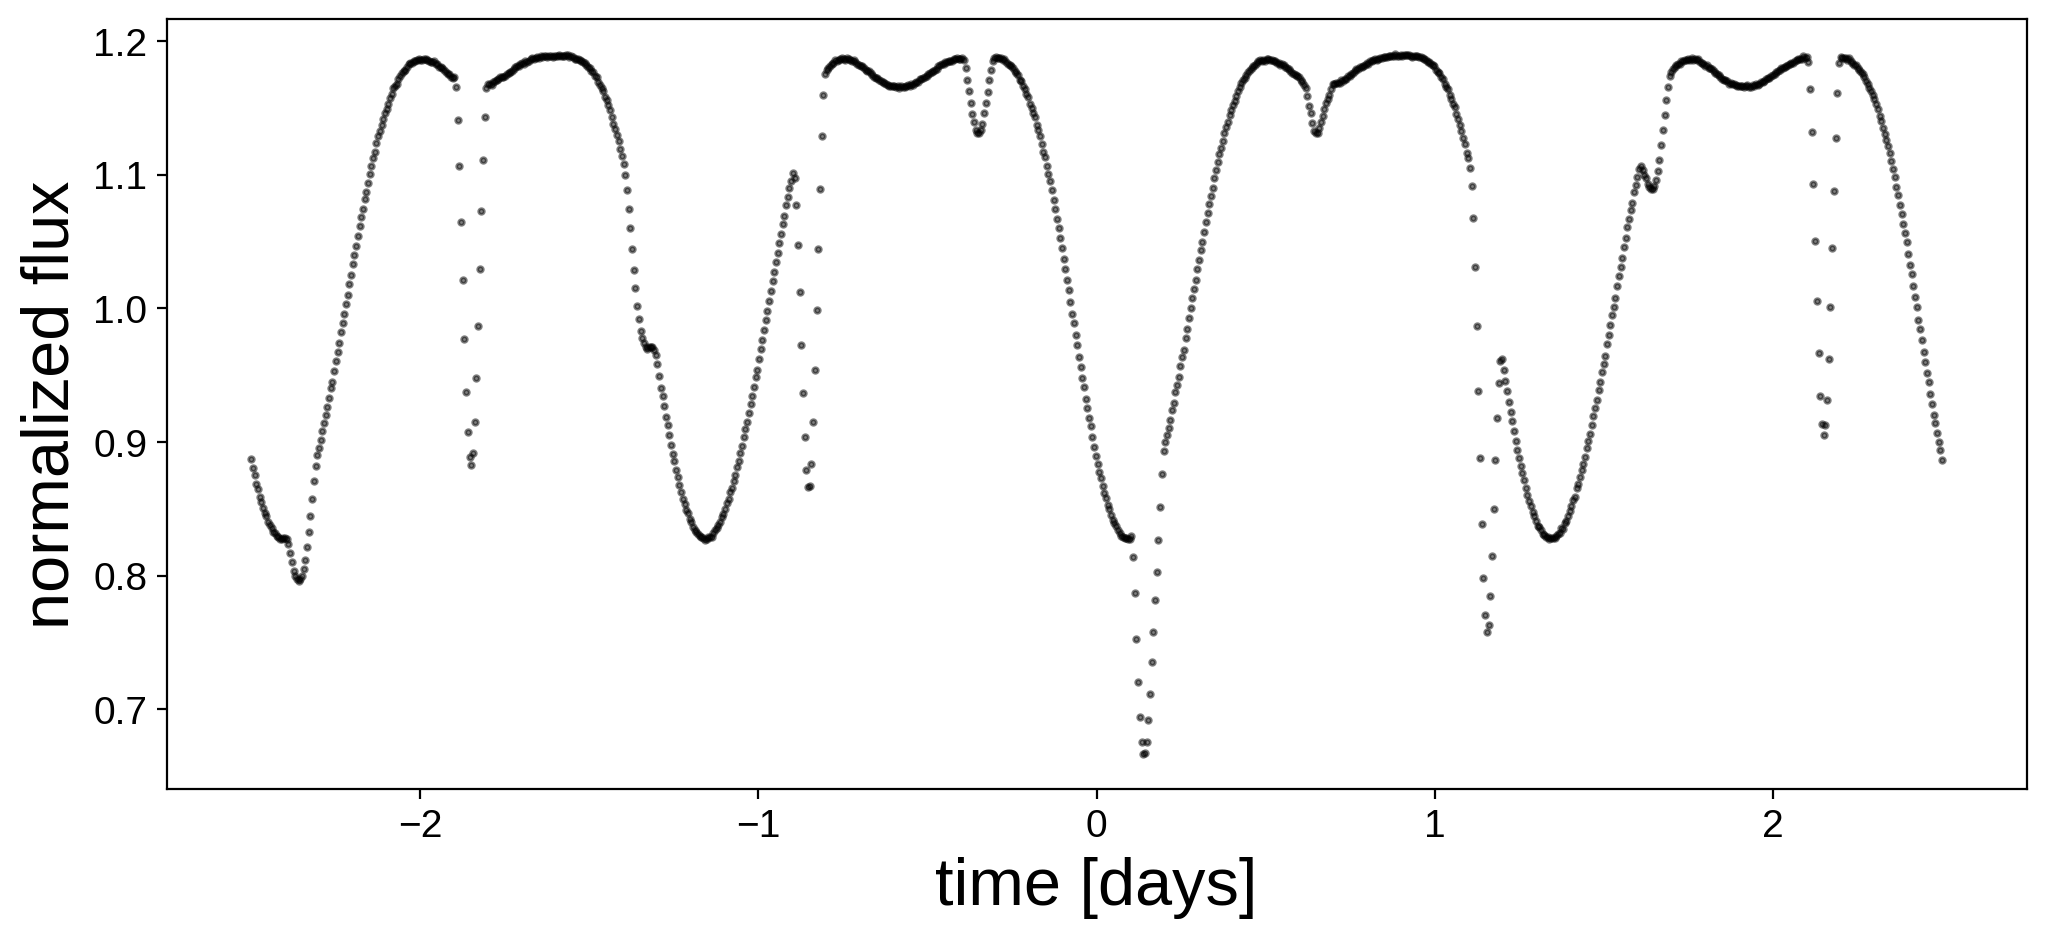

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

We now instantiate the primary, secondary, and system objects within a `pm.Model()` context.
Here are the priors we are going to assume for the parameters of the primary (same as in the previous notebook):

| Parameter      | True Value | Assumed Value / Prior     | Units          |
| ---            | ---        | ---                       | ---            |
|$\mathrm{amp}$  | $1.0$      | $1.0$                     | $-$            |
|$r$             | $1.0$      | $\mathcal{N}(0.95,0.1^2)$ | $R_\odot$      |
|$m$             | $1.0$      | $\mathcal{N}(1.05,0.1^2)$ | $M_\odot$      |
|$P_\mathrm{rot}$| $1.25$     | $\mathcal{N}(1.25,0.01^2)$| $\mathrm{days}$|
|$i$             | $80.0$     | $\mathcal{N}(80.0,5.0^2)$ | $\mathrm{deg}$ |
|$u_1$           | $0.40$     | $0.40$                    | $-$            |
|$u_2$           | $0.25$     | $0.25$                    | $-$            |

And here are the priors we are going to assume for the secondary (again, same as in the previous notebook):

| Parameter      | True Value | Assumed Value / Prior      | Units          |
| ---            | ---        | ---                        | ---            |
|$\mathrm{amp}$  | $0.1$      | $0.1$                      | $-$            |
|$r$             | $0.7$      | $\mathcal{N}(0.75,0.1^2)$  | $R_\odot$      |
|$m$             | $0.7$      | $\mathcal{N}(0.70,0.1^2)$  | $M_\odot$      |
|$P_\mathrm{rot}$| $0.625$    | $\mathcal{N}(0.625,0.01^2)$| $\mathrm{days}$|
|$P_\mathrm{orb}$| $1.0$      | $\mathcal{N}(1.01,0.01^2)$ | $\mathrm{days}$|
|$t_0$           | $0.15$     | $\mathcal{N}(0.15,0.001^2)$| $\mathrm{days}$|
|$i$             | $80.0$     | $\mathcal{N}(80.0,5.0^2)$  | $\mathrm{deg}$ |
|$e$             | $0.0$      | $0.0$                      | $-$            |
|$\Omega$        | $0.0$      | $0.0$                      | $\mathrm{deg}$ |
|$u_1$           | $0.20$     | $0.20$                     | $-$            |
|$u_2$           | $0.05$     | $0.05$                     | $-$            |

Above, $\mathcal{N}$ denotes a 1-d normal prior with a given mean and variance. Note that for simplicity we are **fixing** the limb darkening coefficients at their true value.

In [7]:
with pm.Model() as model:

    # Some of the gaussians have significant support at < 0
    # Let's force them to be positive (required for quantites
    # such as radius, mass, etc.)
    # NOTE: When using `pm.Bound`, it is *very important* to
    # explicitly define a `testval` -- otherwise this defaults
    # to unity. Since the `testval` is used to initialize the
    # optimization step, it's very important we start at
    # reasonable values, otherwise things will never converge!
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)

    # Primary
    A_inc = pm.Normal("A_inc", mu=80, sd=5, testval=80)
    A_amp = 1.0
    A_r = PositiveNormal("A_r", mu=0.95, sd=0.1, testval=0.95)
    A_m = PositiveNormal("A_m", mu=1.05, sd=0.1, testval=1.05)
    A_prot = PositiveNormal("A_prot", mu=1.25, sd=0.01, testval=1.25)
    pri = starry.Primary(
        starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A_inc, amp=A_amp),
        r=A_r,
        m=A_m,
        prot=A_prot,
    )
    pri.map[1] = A["u"][0]
    pri.map[2] = A["u"][1]

    # Secondary
    B_inc = pm.Normal("B_inc", mu=80, sd=5, testval=80)
    B_amp = 0.1
    B_r = PositiveNormal("B_r", mu=0.75, sd=0.1, testval=0.75)
    B_m = PositiveNormal("B_m", mu=0.70, sd=0.1, testval=0.70)
    B_prot = PositiveNormal("B_prot", mu=0.625, sd=0.01, testval=0.625)
    B_porb = PositiveNormal("B_porb", mu=1.01, sd=0.01, testval=1.01)
    B_t0 = pm.Normal("B_t0", mu=0.15, sd=0.001, testval=0.15)
    sec = starry.Secondary(
        starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B_inc, amp=B_amp),
        r=B_r,
        m=B_m,
        porb=B_porb,
        prot=B_prot,
        t0=B_t0,
        inc=B_inc,
    )
    sec.map[1] = B["u"][0]
    sec.map[2] = B["u"][1]

    # System
    sys = starry.System(pri, sec)

Now let's define our likelihood function. Normally we would call something like `pm.Normal` to define our data likelihood, but since we're analytically marginalizing over the surface maps, we use the `lnlike` method in the `System` object instead. We pass this to `pymc3` via a `Potential`, which allows us to define a custom likelihood function. Note that in order for this to work we need to set gaussian priors on the spherical harmonic coefficients; we give them zero mean and covariance $\Lambda = 10^{-2}I$ as in the previous notebooks.

Note, also, that at no point have we set the map coefficients of either object. These are never used -- we're marginalizing over them analytically!

In [8]:
with model:
    sys.set_data(flux, C=sigma ** 2)
    pri.map.set_prior(L=1e-2)
    sec.map.set_prior(L=1e-2)
    pm.Potential("marginal", sys.lnlike(t=t))

Now that we've specified the model, it's a good idea to run a quick gradient descent to find the MAP (maximum a posteriori) solution. This will give us a decent starting point for the inference problem.

In [9]:
%%time
with model:
    map_soln = xo.optimize()

optimizing logp for variables: [B_t0, B_porb, B_prot, B_m, B_r, B_inc, A_prot, A_m, A_r, A_inc]
74it [00:02, 30.64it/s, logp=5.900942e+03] 

CPU times: user 41.6 s, sys: 2.26 s, total: 43.9 s
Wall time: 25.2 s



message: Desired error not necessarily achieved due to precision loss.
logp: -359093.43938379525 -> 5900.942147236615


To see how we did, let's plot the best fit solution. We don't have values for the coefficients (because we marginalized over them), so what we do to get a light curve is we *solve* for the coefficients (using `sys.solve()`), conditioned on the best fit values for the orbital parameters. We then set the map coefficients and compute the light curve model using `sys.flux()`. Note that we need to wrap some things in `xo.eval_in_model()` in order to get numerical values out of the `pymc3` model.

In [16]:
with model:
    yhat = xo.eval_in_model(sys.solve(t=t)[0], point=map_soln)
    pri.map[1:, :] = yhat[: pri.map.Ny - 1]
    sec.map[1:, :] = yhat[pri.map.Ny - 1 :]
    flux_model = xo.eval_in_model(sys.flux(t=t), point=map_soln)

Here's our model next to the data. We're doing quite well!

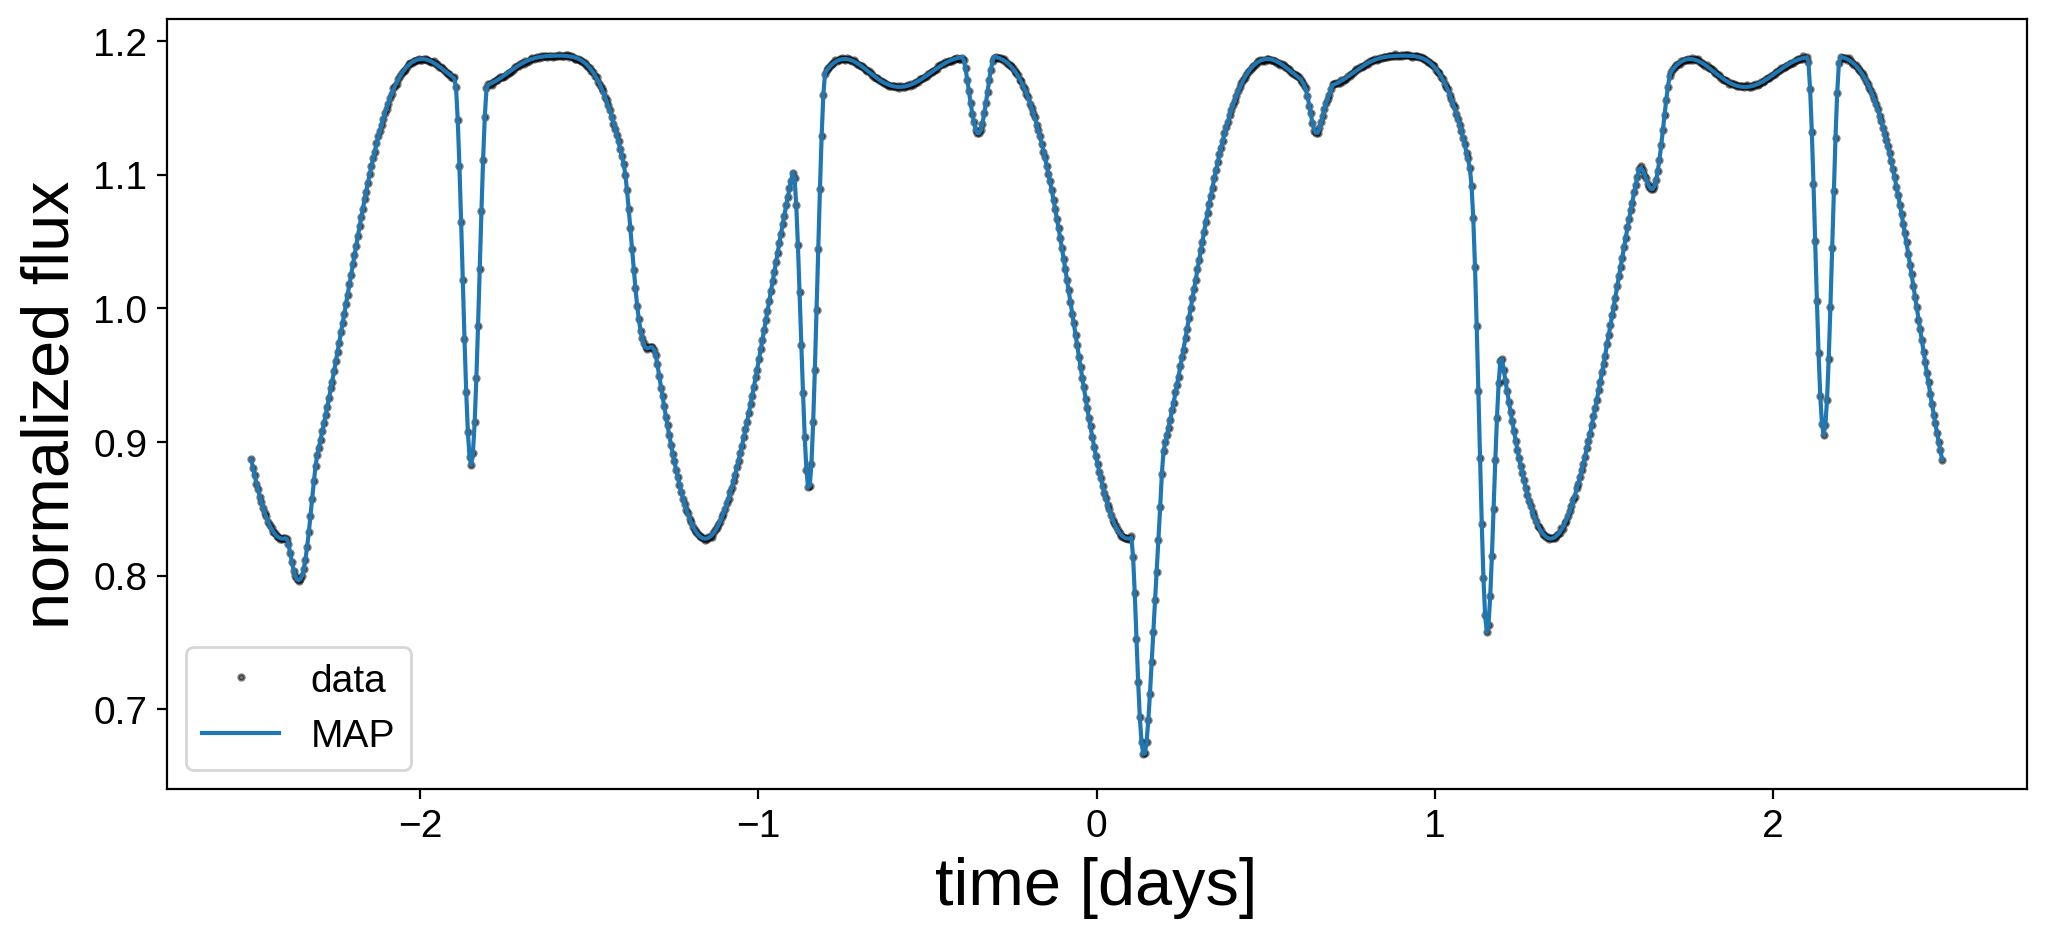

In [17]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4, label="data")
ax.plot(t, flux_model, "C0", label="MAP")
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24)
ax.legend();

And here's what our maps look like. Note that these correspond to the posterior mean of the spherical harmonic coefficients conditioned on the best fitting orbital solution. (Note also that we need to instantiate new maps here so we can visualize them; otherwise `pymc3` will complain).

In [19]:
map = starry.Map(ydeg=A["ydeg"])
map.inc = map_soln["A_inc"]
map[1:, :] = yhat[: pri.map.Ny - 1]
map.show(theta=np.linspace(0, 360, 50))

In [20]:
map = starry.Map(ydeg=B["ydeg"])
map.inc = map_soln["B_inc"]
map[1:, :] = yhat[pri.map.Ny - 1 :]
map.show(theta=np.linspace(0, 360, 50))

Not bad! Now the fun part: sampling. Recall that we are analytically marginalizing over the map coefficients and sampling the nonlinear orbital parameters. This will take a while!

In [21]:
%%time
with model:
    trace = pm.sample(
        tune=1000,
        draws=2500,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_t0, B_porb, B_prot, B_m, B_r, B_inc, A_prot, A_m, A_r, A_inc]
Sampling 4 chains, 81 divergences: 100%|██████████| 14000/14000 [1:37:25<00:00,  2.39draws/s] 
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 37.7 s, sys: 3.27 s, total: 40.9 s
Wall time: 1h 37min 34s


This ran **much faster** than in the previous notebook, where we sampled over the map parameters. We did, however, have divergences and some poor performance along some of the dimensions. But let's check the diagnostics:

In [27]:
var_names_A = ["A_m", "A_r", "A_prot", "A_inc"]
var_names_B = ["B_m", "B_r", "B_porb", "B_prot", "B_inc", "B_t0"]
display(pm.summary(trace, var_names=var_names_A + var_names_B))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
A_m,1.048,0.096,0.872,1.228,0.001,0.001,5216.0,5216.0,5212.0,5167.0,1.0
A_r,1.022,0.028,0.968,1.075,0.000,0.000,7375.0,7375.0,7469.0,5494.0,1.0
A_prot,1.250,0.000,1.250,1.250,0.000,0.000,10267.0,10267.0,10340.0,6962.0,1.0
A_inc,81.270,0.600,80.166,82.398,0.006,0.004,9842.0,9835.0,9836.0,6978.0,1.0
B_m,0.696,0.099,0.526,0.893,0.002,0.001,2355.0,2355.0,2438.0,1592.0,1.0
B_r,0.695,0.022,0.656,0.737,0.000,0.000,5866.0,5866.0,5902.0,2689.0,1.0
B_porb,1.000,0.000,1.000,1.000,0.000,0.000,6102.0,6102.0,6152.0,5965.0,1.0
B_prot,0.625,0.000,0.625,0.625,0.000,0.000,9162.0,9162.0,9287.0,6427.0,1.0
B_inc,79.867,0.232,79.443,80.316,0.002,0.002,10169.0,10169.0,10158.0,7412.0,1.0
B_t0,0.150,0.000,0.150,0.150,0.000,0.000,9260.0,9260.0,9245.0,7005.0,1.0


We actually did pretty well: the `r_hat` diagnostic is unity and the effective sample size (`ess`) is several thousand for most parameters. Also **much better** than in the previous notebook.

In [28]:
# Several hacks to `corner` to make it prettier

try:
    old_corner
except NameError:
    old_corner = corner


def corner(*args, **kwargs):
    # Get the usual corner plot
    figure = old_corner(*args, **kwargs)

    # Get the axes
    ndim = int(np.sqrt(len(figure.axes)))
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Smaller tick labels
    for ax in axes[1:, 0]:
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        ax.yaxis.set_major_formatter(formatter)
    for ax in axes[-1, :]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        ax.xaxis.set_major_formatter(formatter)

    # Pad the axes to always include the truths
    truths = kwargs.get("truths", None)
    if truths is not None:
        for row in range(1, ndim):
            for col in range(row):
                lo, hi = np.array(axes[row, col].get_xlim())
                if truths[col] < lo:
                    lo = truths[col] - 0.1 * (hi - truths[col])
                    axes[row, col].set_xlim(lo, hi)
                    axes[col, col].set_xlim(lo, hi)
                elif truths[col] > hi:
                    hi = truths[col] - 0.1 * (hi - truths[col])
                    axes[row, col].set_xlim(lo, hi)
                    axes[col, col].set_xlim(lo, hi)

                lo, hi = np.array(axes[row, col].get_ylim())
                if truths[row] < lo:
                    lo = truths[row] - 0.1 * (hi - truths[row])
                    axes[row, col].set_ylim(lo, hi)
                    axes[row, row].set_xlim(lo, hi)
                elif truths[row] > hi:
                    hi = truths[row] - 0.1 * (hi - truths[row])
                    axes[row, col].set_ylim(lo, hi)
                    axes[row, row].set_xlim(lo, hi)

    return figure

Here's the corner plot for the posteriors of the primary orbital parameters:

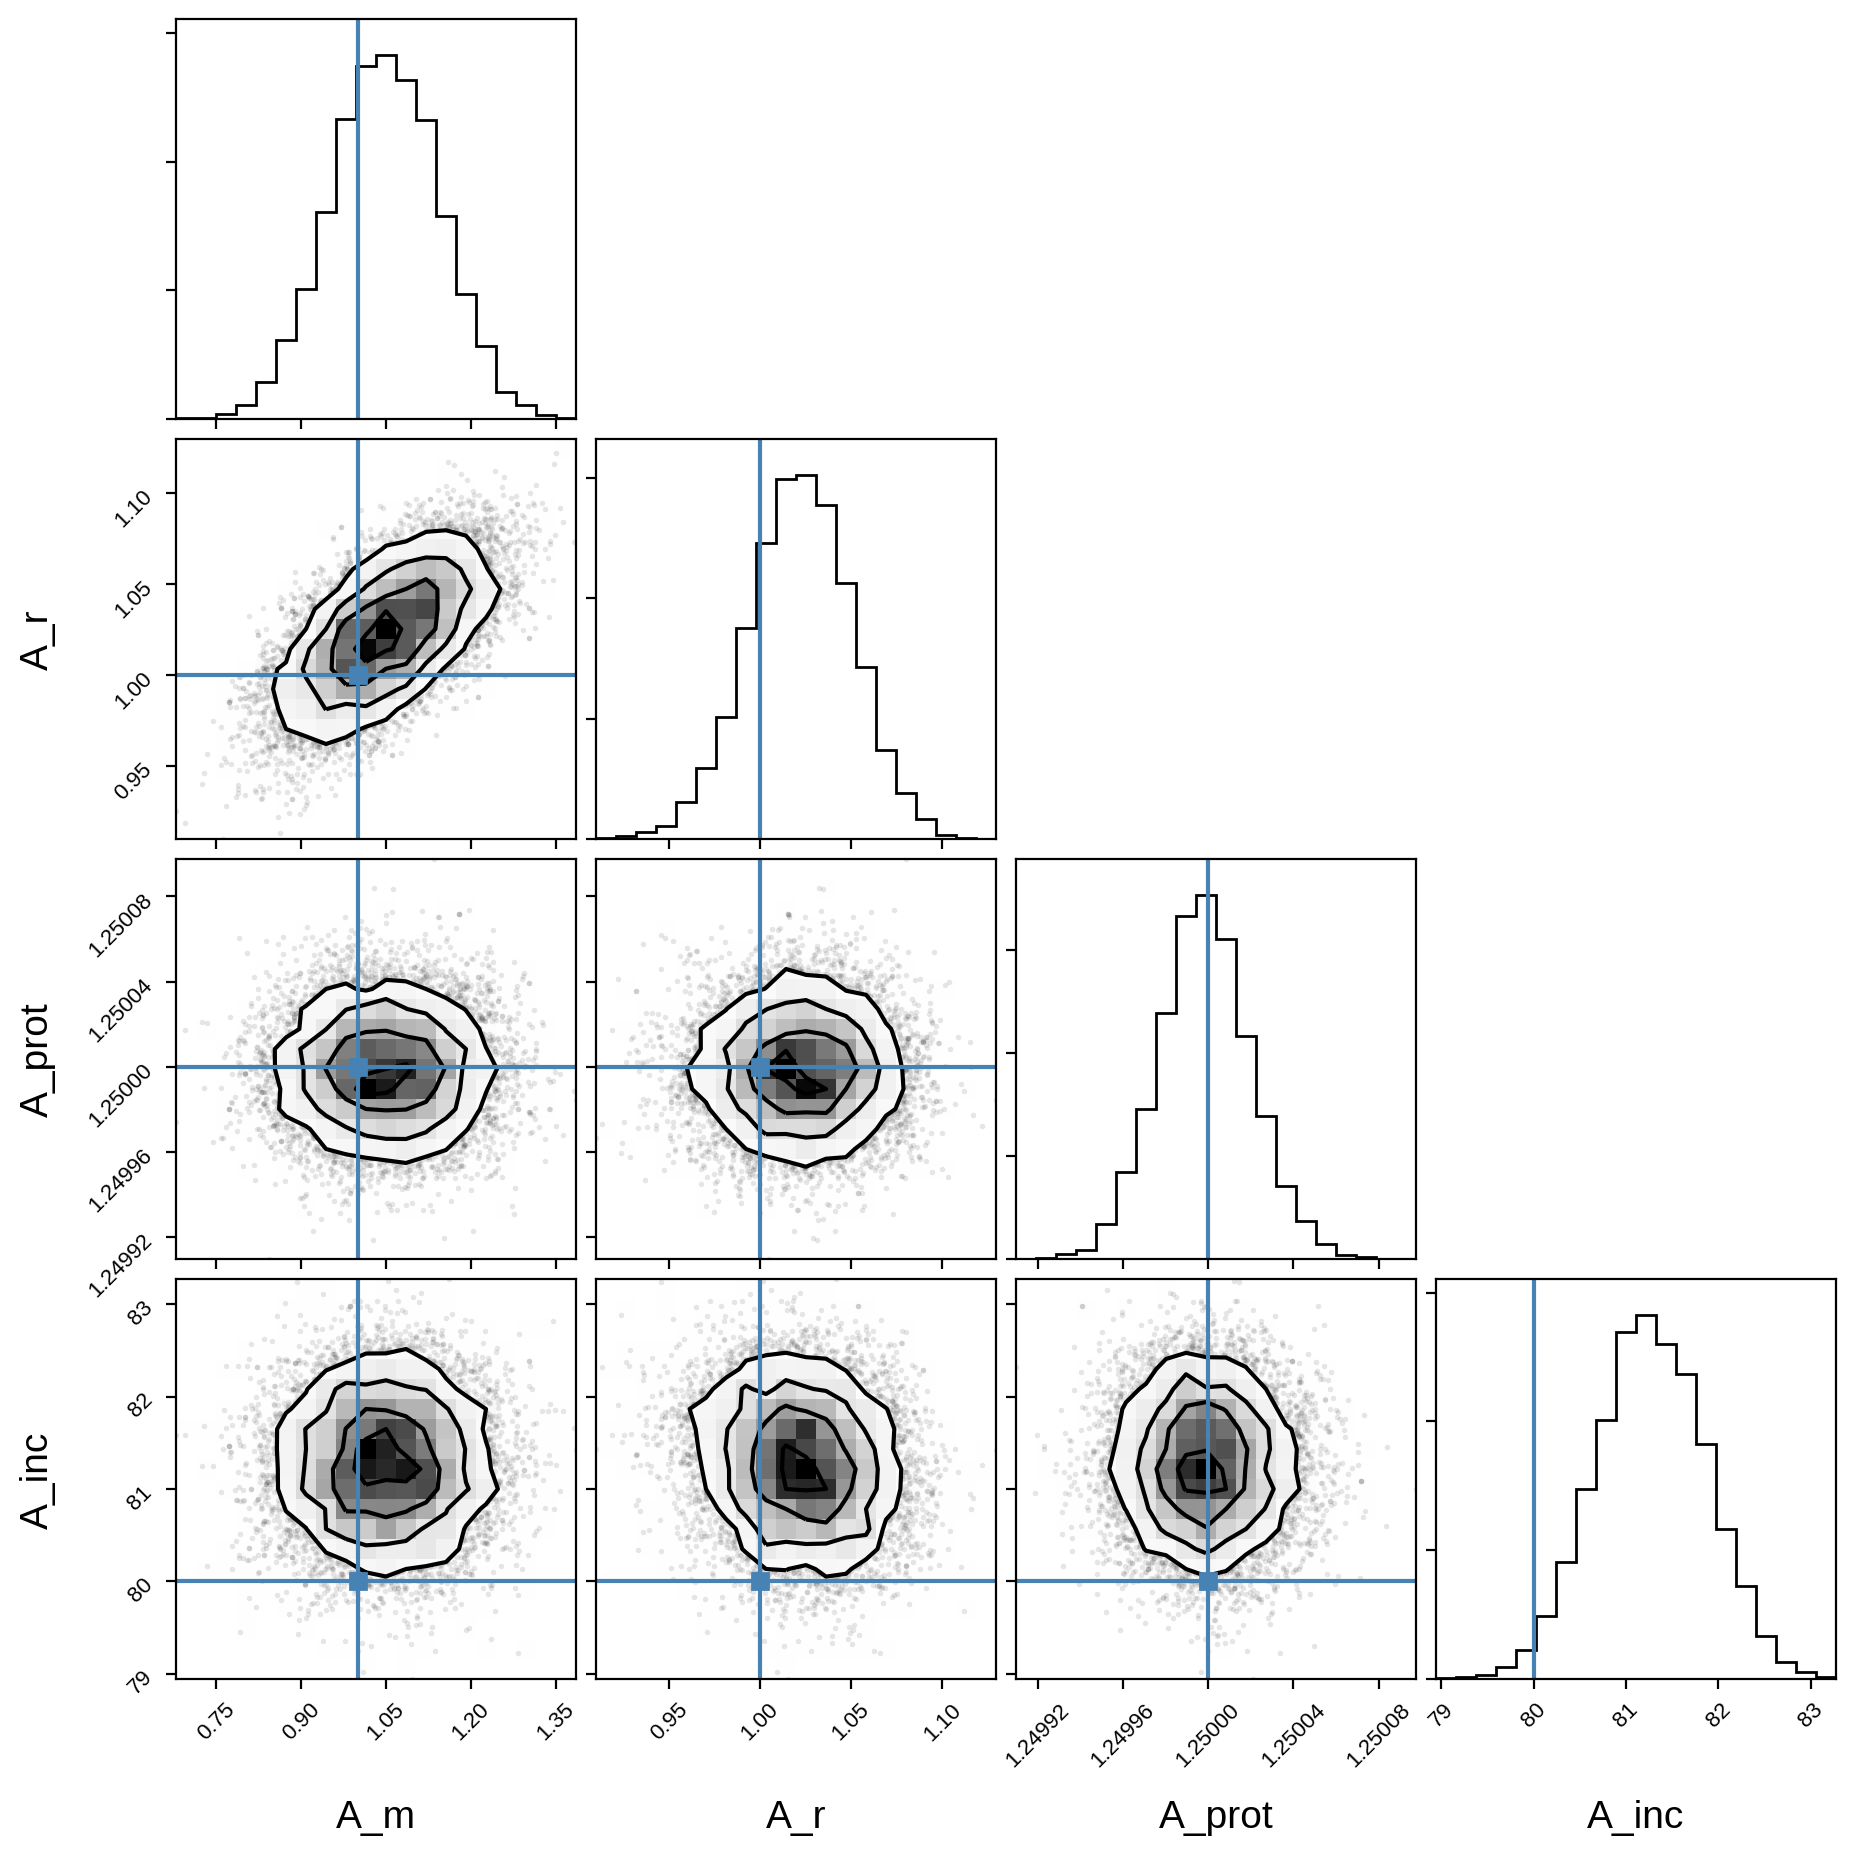

In [30]:
truths_A = [A["m"], A["r"], A["prot"], A["inc"]]
samples_A = pm.trace_to_dataframe(trace, varnames=var_names_A)
corner(samples_A, truths=truths_A);

And here's that same plot for the secondary orbital parameters:

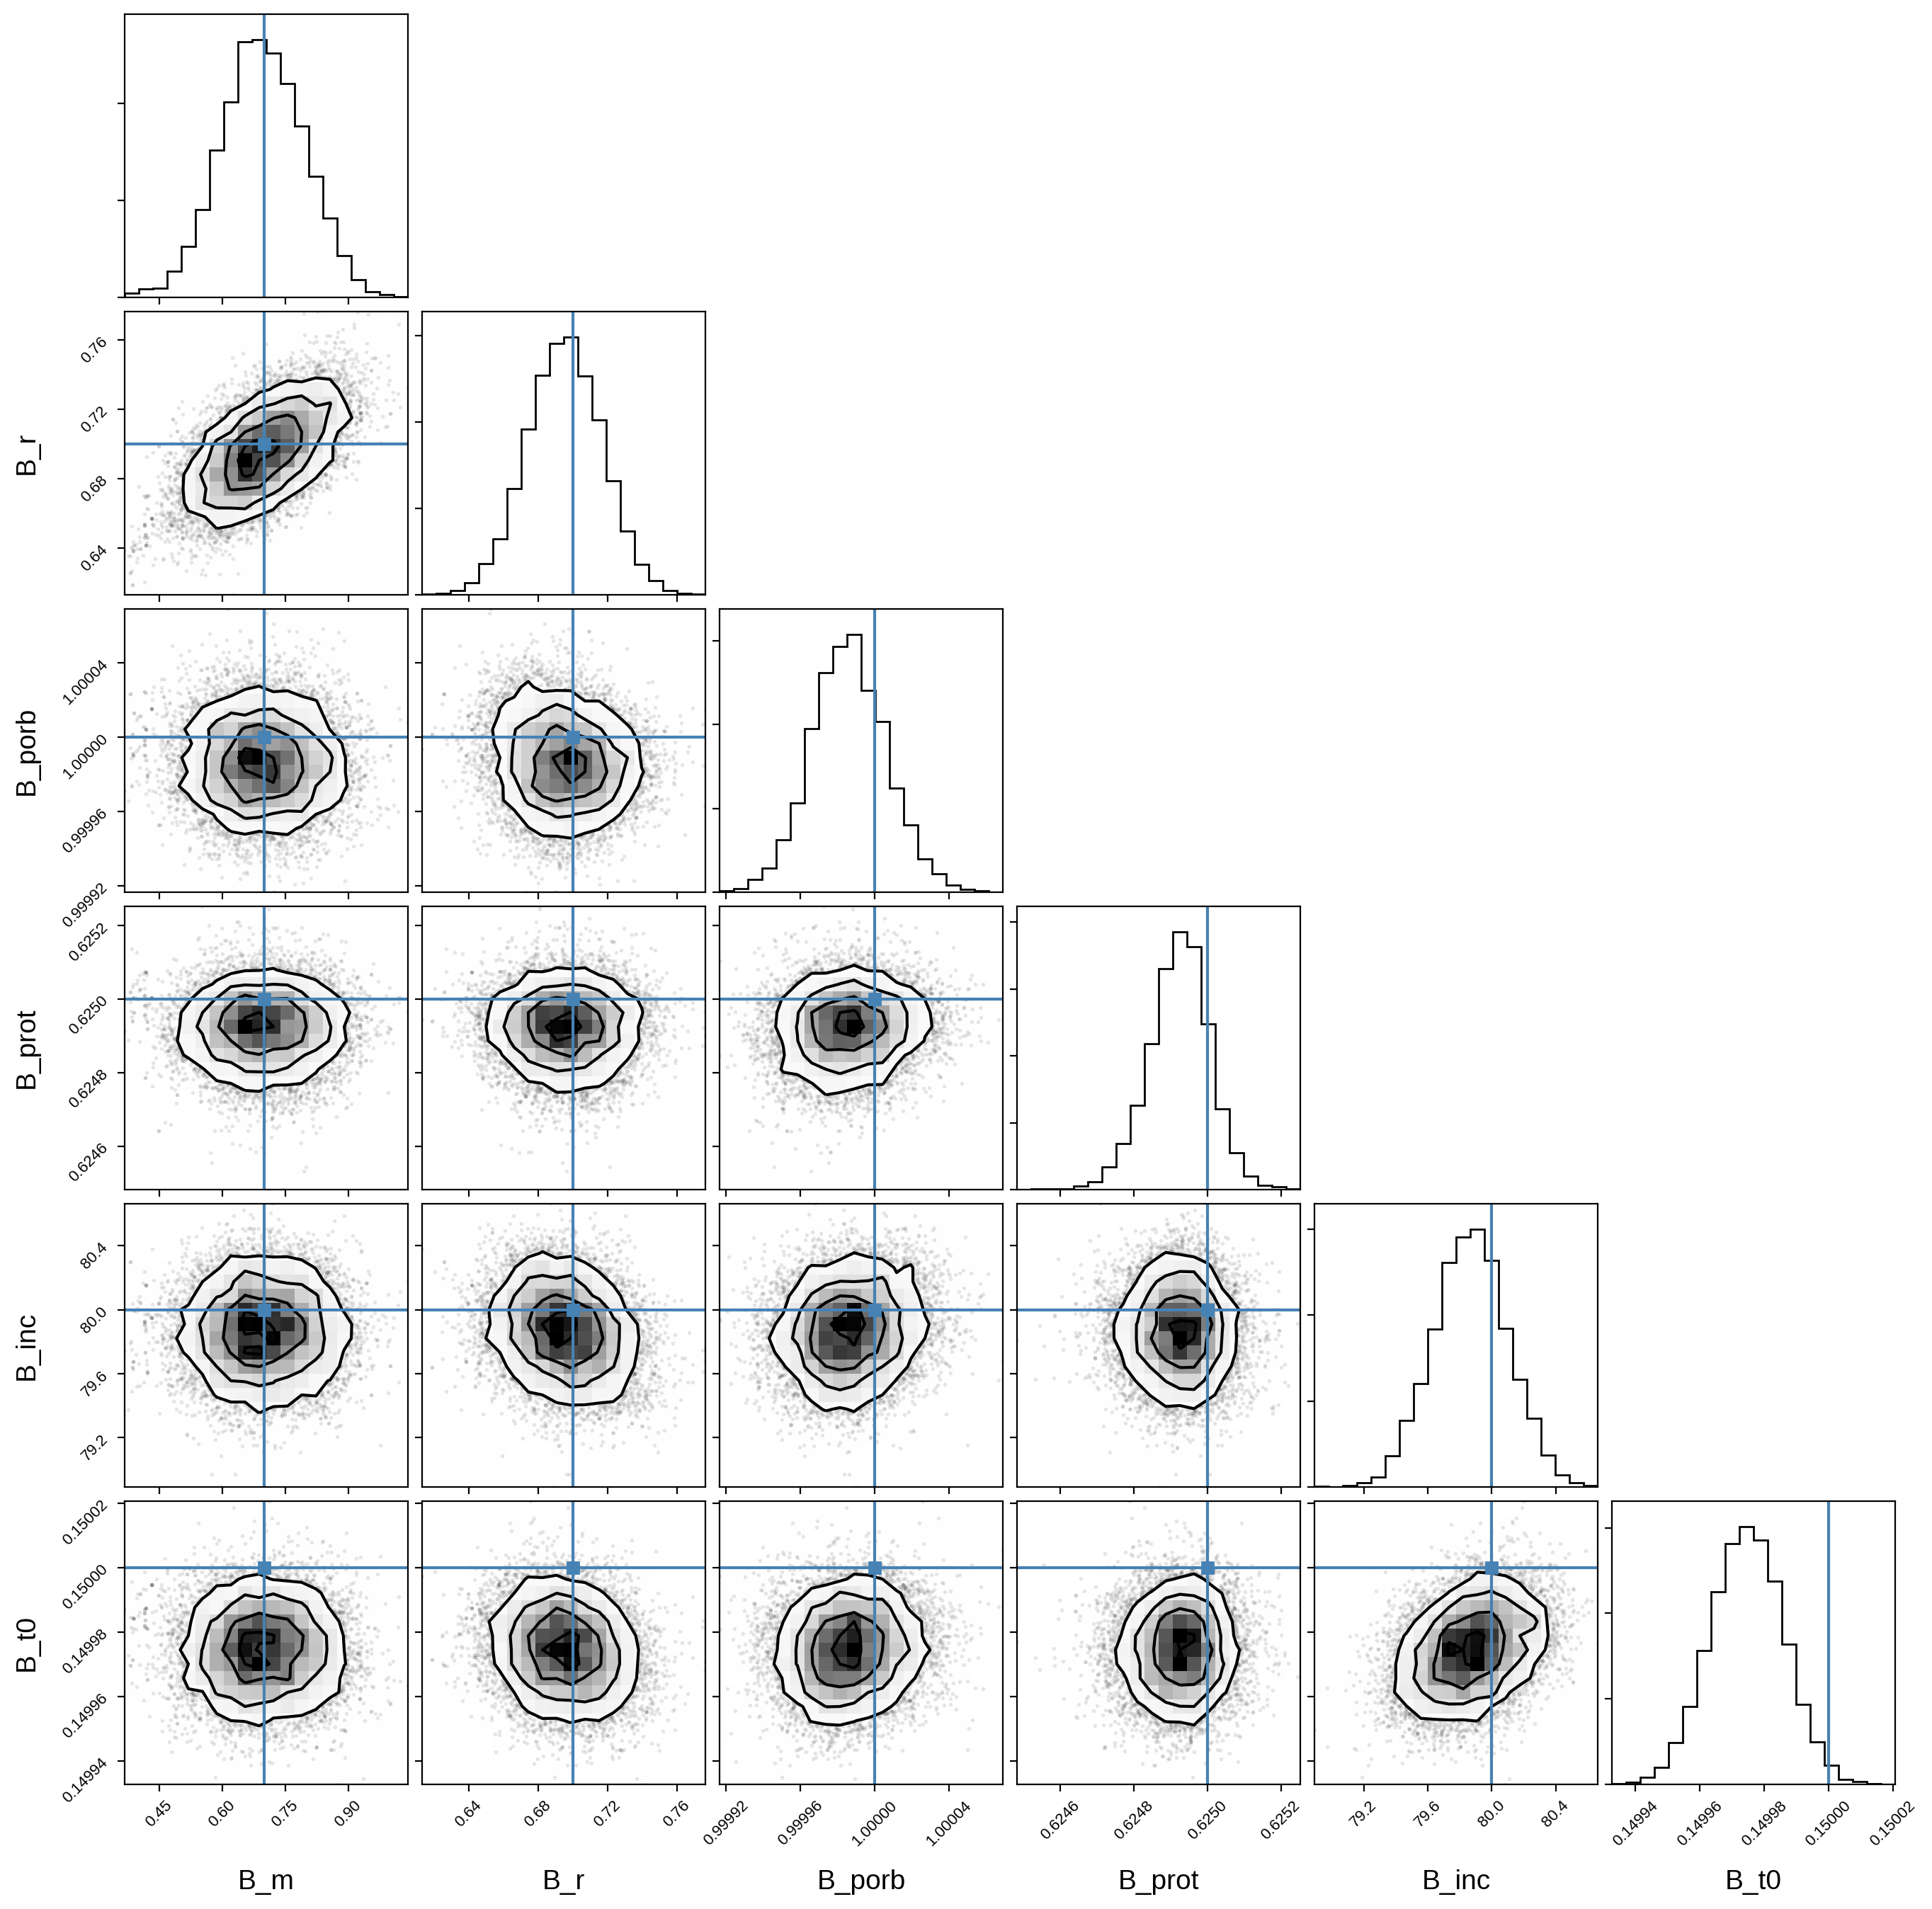

In [31]:
truths_B = [B["m"], B["r"], B["porb"], B["prot"], B["inc"], B["t0"]]
samples_B = pm.trace_to_dataframe(trace, varnames=var_names_B)
corner(samples_B, truths=truths_B);

Note that these are qualitatively identical to the ones we derived in [the previous notebook](EclipsingBinary_FullSolution_Painful.ipynb) (albeit with far more effective samples!)

We can verify that our solution is a good fit to the data by drawing random samples and computing the corresponding light curves. We did a similar thing up top, except here we're actually drawing samples from the map posterior.

In [57]:
np.random.seed(1)
nsamples = 30
yhat = np.zeros((nsamples, pri.map.Ny - 1 + sec.map.Ny - 1))
pri_y_draw = np.zeros((nsamples, pri.map.Ny - 1))
sec_y_draw = np.zeros((nsamples, sec.map.Ny - 1))
flux_model = np.zeros((nsamples, len(t)))
with model:
    for i in tqdm(range(nsamples)):
        idx = np.random.randint(len(trace))
        point = trace.point(idx)
        # Solve the linear problem and draw a sample
        sys.solve(t=t)
        sys.draw()
        # Get the numerical values using `xo.eval_in_model`
        pri_y_draw[i], sec_y_draw[i], flux_model[i] = xo.eval_in_model(
            [pri.map[1:, :], sec.map[1:, :], sys.flux(t=t)], point=point
        )

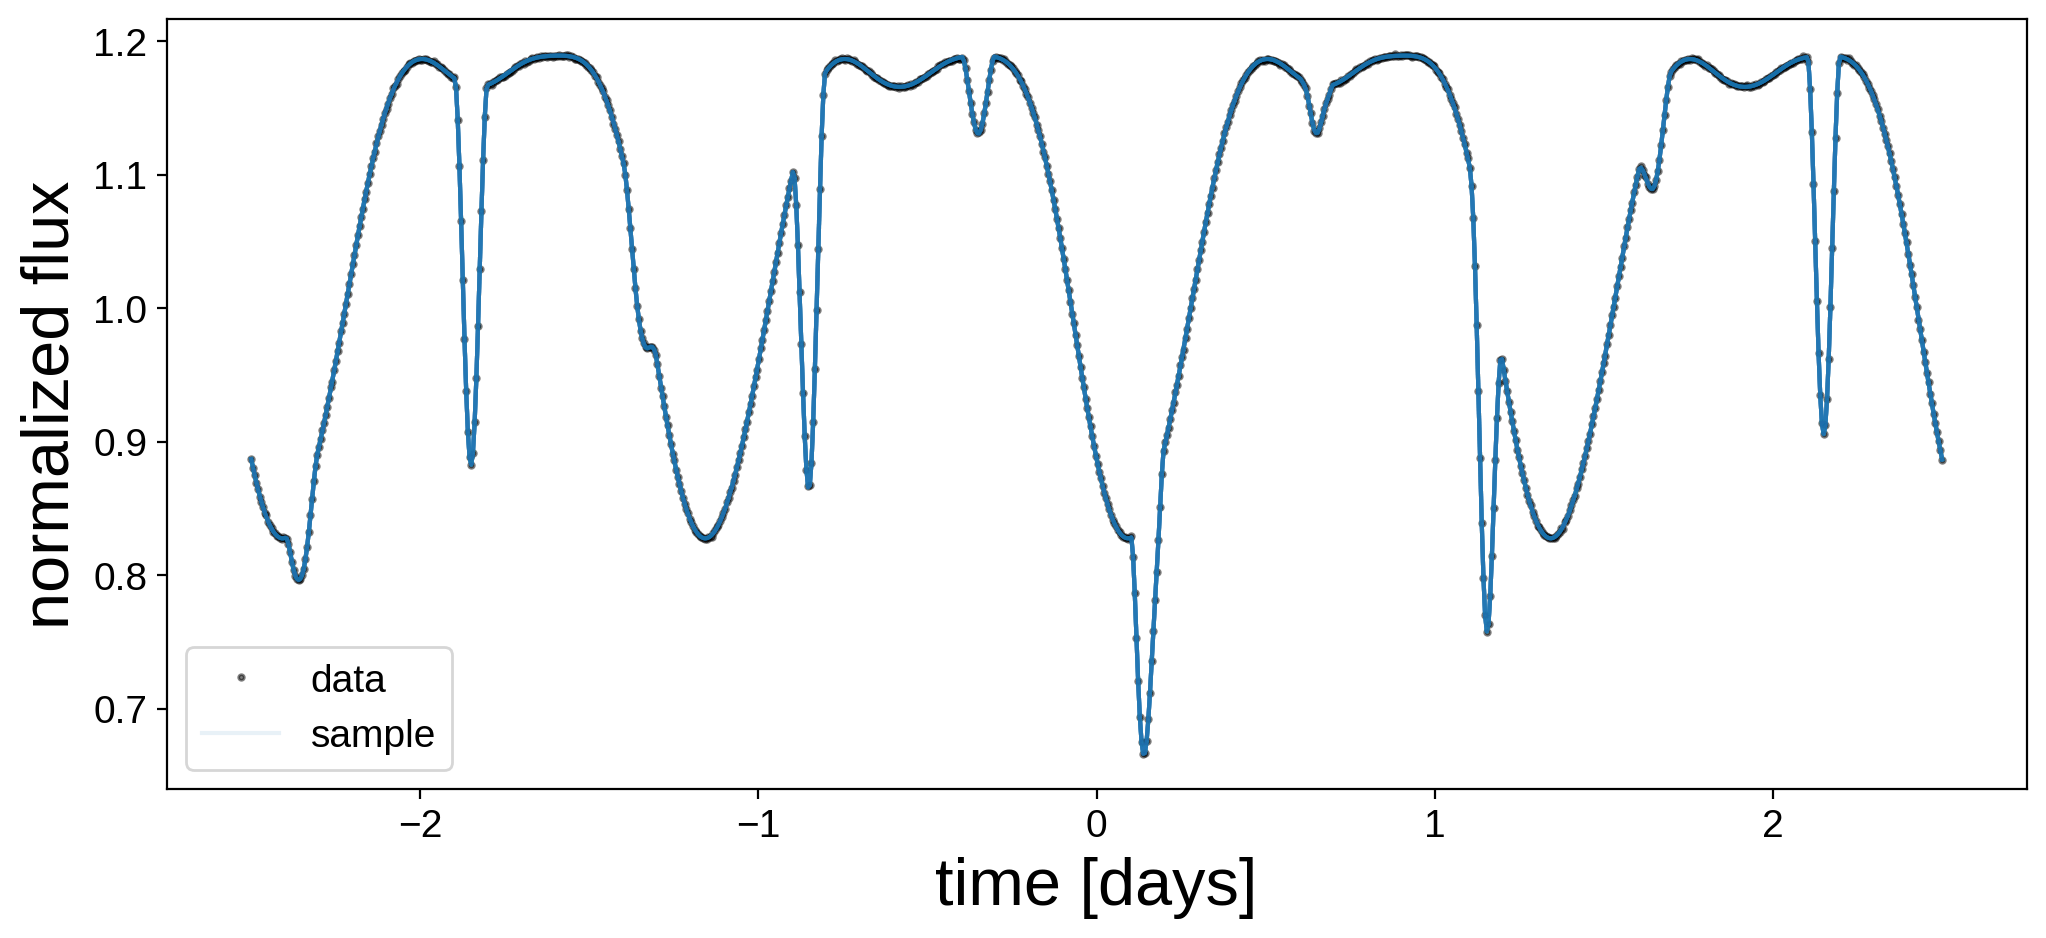

In [58]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4, label="data")
label = "sample"
for i in range(nsamples):
    ax.plot(t, flux_model[i], "C0", label=label, alpha=0.1)
    label = None
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24)
ax.legend();

Finally, let's plot the true map next to the mean map and a random sample for each body.

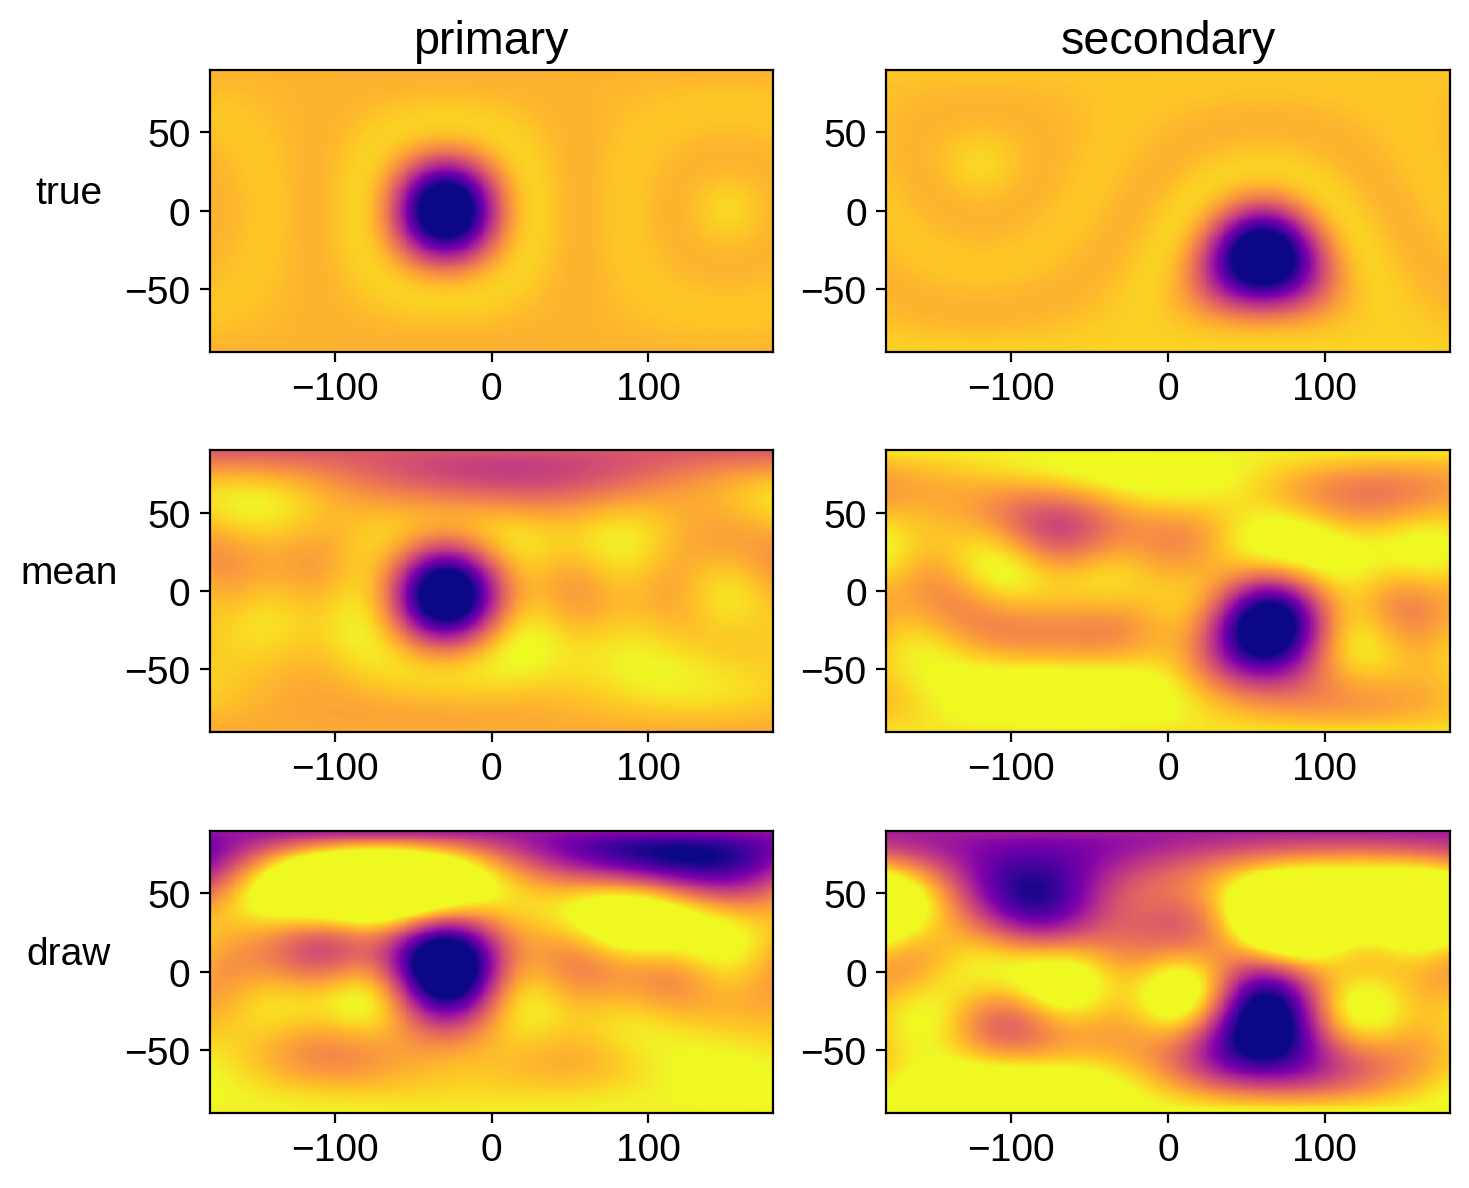

In [59]:
map = starry.Map(ydeg=A["ydeg"])
map[1:, :] = np.mean(pri_y_draw, axis=0)
pri_mu = map.render(projection="rect").eval()
map[1:, :] = pri_y_draw[0]
pri_draw = map.render(projection="rect").eval()
map[1:, :] = A["y"]
pri_true = map.render(projection="rect").eval()

map = starry.Map(ydeg=B["ydeg"])
map[1:, :] = np.mean(sec_y_draw, axis=0)
sec_mu = map.render(projection="rect").eval()
map[1:, :] = sec_y_draw[0]
sec_draw = map.render(projection="rect").eval()
map[1:, :] = B["y"]
sec_true = map.render(projection="rect").eval()

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

That looks great!